# Try to generate heatmap from eye image

In [1]:
# Steps:
# 1. get data: that's eye images + corresponding heatmaps
# 2. build CNN architecture (inspire yourself from CCNN)
# 3. train. see results.
# 4. extract landmark from heatmap
import os
import torch
import cv2
import random
import numpy as np
import time
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# 1. Get data: eye images + corresponding heatmaps
eye_images = os.listdir('./crowdpupil/images')
eye_images.sort()
heatmaps = os.listdir('./crowdpupil/heatmaps')
heatmaps.sort()

img_width = 256
img_height = 200
# img_width = 1000//4
# img_height = 776//4

# load images
for index, f in enumerate(eye_images):
    img = cv2.imread('./crowdpupil/images/' + f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_AREA)
    img = img.reshape(1, img_height, img_width)
    img = img/255
    img = torch.from_numpy(img).float()
    eye_images[index] = img

# load heatmaps
for index, f in enumerate(heatmaps):
    img = cv2.imread('./crowdpupil/heatmaps/' + f, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_AREA)
    img = img.reshape(1, img_height, img_width)
    img = img/255
    img = torch.from_numpy(img).float()
    heatmaps[index] = img
    
# split train/test
split_size = 0.8
train_size = int(len(eye_images) * split_size)
train_data = list(zip(eye_images[:train_size], heatmaps[:train_size]))
test_data = list(zip(eye_images[train_size:], heatmaps[train_size:]))

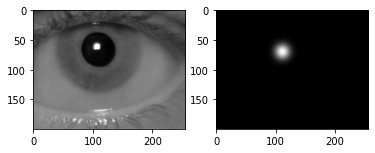

In [3]:
# Visualize the data
choice = random.randint(0, len(eye_images))
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(eye_images[choice].squeeze(), cmap='gray')
axarr[1].imshow(heatmaps[choice].squeeze(), cmap='gray')

In [85]:
# Step 2. Build the CNN architecture. Input: eye image. Output: heatmap.
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class MyCNN(nn.Module):
    def __init__(self, input_size):
        super(MyCNN, self).__init__()
        ## eye image -> encoder -> decoder -> heatmap
        ## input: 200 x 256
        
        filters = [16, 32, 64, 128]
        
        # starting encoding
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, filters[0], kernel_size=3, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters[0]),
            
            nn.Conv2d(filters[0], filters[1], kernel_size=2, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters[1]),
            
            nn.Conv2d(filters[1], filters[2], kernel_size=3, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters[2]),
            
            nn.Conv2d(filters[2], filters[3], kernel_size=2, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters[3]),
        )
        # encoding done
        # starting decoding
        self.layer2 = nn.Sequential(
            nn.Upsample(size=(28, 35), mode='bilinear'),
            nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters[2]),
            
            nn.Upsample(size=(54, 68), mode='bilinear'),
            nn.ConvTranspose2d(filters[2], filters[1], kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters[1]),
            
            nn.Upsample(size=(104, 132), mode='bilinear'),
            nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters[0]),
        
            nn.Upsample(size=(202, 258), mode='bilinear'),
            nn.ConvTranspose2d(filters[0], 1, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1),
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return (x)

In [88]:
# Create training and test dataloaders
num_workers = 0
# how many samples per batch to load
batch_size = 32
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [89]:
# train the model
model = MyCNN(input_size=(img_height, img_width))
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
my_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1, 2, 3, 5, 7, 10], gamma = 0.1)

# number of epochs to train the model
n_epochs = 12

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    start_time = time.time()
    
    ###################
    # train the model #
    ###################
    for i, data in enumerate(train_loader, 1):
        # no need to flatten images
        images, heatmaps = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, heatmaps)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * images.size(0)
        print (f'epoch {epoch} batch {i} item loss: {loss.item() * images.size(0)}')
            
    my_lr_scheduler.step()
    
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f} \t Training time: {:.6f}'.format(
        epoch, 
        train_loss,
        time.time() - start_time
        ))

epoch 1 batch 1 item loss: 32.271827697753906
epoch 1 batch 2 item loss: 31.02176284790039
epoch 1 batch 3 item loss: 28.473569869995117
epoch 1 batch 4 item loss: 26.284442901611328
epoch 1 batch 5 item loss: 24.770191192626953
epoch 1 batch 6 item loss: 23.254928588867188
epoch 1 batch 7 item loss: 21.800336837768555
epoch 1 batch 8 item loss: 20.484251022338867
epoch 1 batch 9 item loss: 19.710477828979492
epoch 1 batch 10 item loss: 18.545509338378906
epoch 1 batch 11 item loss: 17.607044219970703
epoch 1 batch 12 item loss: 16.712539672851562
epoch 1 batch 13 item loss: 15.752289772033691
epoch 1 batch 14 item loss: 14.958069801330566
epoch 1 batch 15 item loss: 14.141331672668457
epoch 1 batch 16 item loss: 13.299895286560059
epoch 1 batch 17 item loss: 12.665275573730469
epoch 1 batch 18 item loss: 11.92805290222168
epoch 1 batch 19 item loss: 11.145808219909668
epoch 1 batch 20 item loss: 8.16945880651474
Epoch: 1 	Training Loss: 19.149853 	 Training time: 84.692294
epoch 2 bat

epoch 9 batch 11 item loss: 8.56218147277832
epoch 9 batch 12 item loss: 8.486631393432617
epoch 9 batch 13 item loss: 8.539730072021484
epoch 9 batch 14 item loss: 8.505766868591309
epoch 9 batch 15 item loss: 8.470617294311523
epoch 9 batch 16 item loss: 8.609319686889648
epoch 9 batch 17 item loss: 8.564183235168457
epoch 9 batch 18 item loss: 8.530383110046387
epoch 9 batch 19 item loss: 8.506359100341797
epoch 9 batch 20 item loss: 6.6376276314258575
Epoch: 9 	Training Loss: 8.423467 	 Training time: 64.628564
epoch 10 batch 1 item loss: 8.560375213623047
epoch 10 batch 2 item loss: 8.521717071533203
epoch 10 batch 3 item loss: 8.483260154724121
epoch 10 batch 4 item loss: 8.499899864196777
epoch 10 batch 5 item loss: 8.479728698730469
epoch 10 batch 6 item loss: 8.52258586883545
epoch 10 batch 7 item loss: 8.494039535522461
epoch 10 batch 8 item loss: 8.526766777038574
epoch 10 batch 9 item loss: 8.533090591430664
epoch 10 batch 10 item loss: 8.473310470581055
epoch 10 batch 11 i

In [318]:
# let's see the model's result
# obtain one batch of test images
dataiter = iter(test_loader)
images, heatmaps = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, img_height, img_width)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

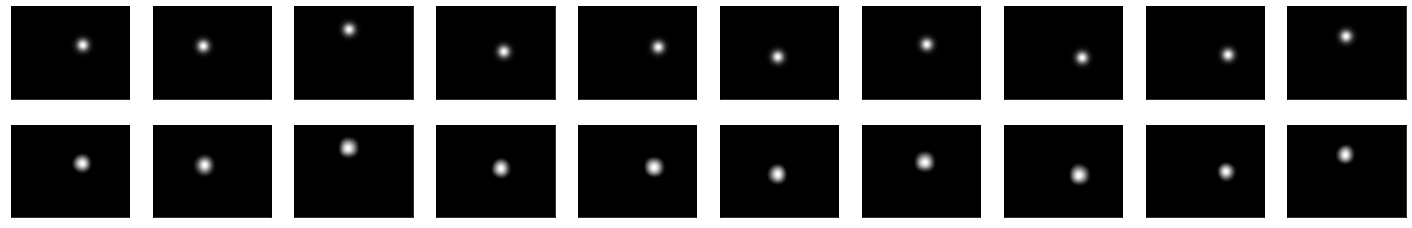

In [330]:
# visualize model predictions
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25, 4))

# input images on top row, reconstructions on bottom
for images, row in zip([heatmaps, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.savefig('/Users/sergiuiacob/Desktop/test.png')

In [78]:
torch.save(model.state_dict(), './models/pytorch_200_256_hourglass_6')

# Test it on real data

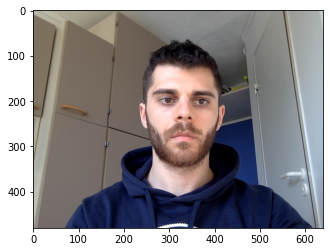

In [354]:
imgs = os.listdir('./data/images/')
cv2_image = cv2.imread('./data/images/' + random.choice(imgs))
cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
plt.imshow(cv2_image)

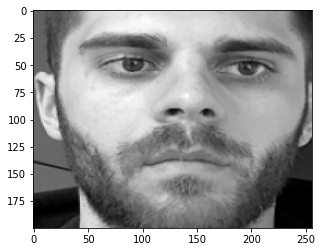

In [355]:
import src.utils as Utils
import importlib
from src.face_detector import *
importlib.reload(src.face_detector)
eyes = extract_face(cv2_image)
eye = Utils.resize_cv2_image(eyes, fixed_dim=(256, 200))
eye = Utils.convert_to_gray_image(eye)
eye = torch.from_numpy(eye).float().reshape((1, 1, 200, 256))

plt.imshow(eye.squeeze(), cmap='gray')
output = model(eye)
# point = lm_from_hm(output)[0].flatten()
# plt.plot(point[0], point[1], marker='o')

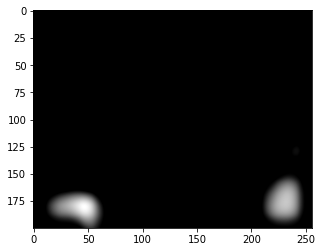

In [356]:
output = model(eye)
plt.imshow(output.detach().numpy().squeeze(), cmap='gray')
# point = lm_from_hm(output)[0].flatten()
# plt.plot(point[0], point[1], marker='o')

In [309]:
def lm_from_hm(hm, center=None, scale=None):
    max, idx = torch.max(
        hm.contiguous().view(hm.size(0), hm.size(1), hm.size(2) * hm.size(3)), 2)
    idx += 1
    preds = idx.view(idx.size(0), idx.size(1), 1).repeat(1, 1, 2).float()
    preds[..., 0].apply_(lambda x: (x - 1) % hm.size(3) + 1)
    preds[..., 1].add_(-1).div_(hm.size(2)).floor_().add_(1)

    for i in range(preds.size(0)):
        for j in range(preds.size(1)):
            hm_ = hm[i, j, :]
            pX, pY = int(preds[i, j, 0]) - 1, int(preds[i, j, 1]) - 1
            if pX > 0 and pX < 63 and pY > 0 and pY < 63:
                diff = torch.FloatTensor(
                    [hm_[pY, pX + 1] - hm_[pY, pX - 1],
                        hm_[pY + 1, pX] - hm_[pY - 1, pX]])
                preds[i, j].add_(diff.sign_().mul_(.25))

    preds.add_(-.5)

    preds_orig = torch.zeros(preds.size())
    if center is not None and scale is not None:
        for i in range(hm.size(0)):
            for j in range(hm.size(1)):
                preds_orig[i, j] = transform(
                    preds[i, j], center, scale, hm.size(2), True)

    return preds, preds_orig